In [2]:
# pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.2/656.2 kB 6.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
df = pd.read_csv('./data/tr_eikon_eod_data.csv', index_col = 0, parse_dates = True)

In [6]:
data = df[['AAPL.O','MSFT.O','INTC.O','AMZN.O','GS.N']].dropna()
AAPL = data['AAPL.O']
MSFT = data['MSFT.O']
INTC = data['INTC.O']
AMZN = data['AMZN.O']
GS = data['GS.N']

In [7]:
def get_pre(raw, order):
    
    def arima_forecast(traindata, obs):
        model = ARIMA(traindata, order=order).fit()
        pre_y = model.forecast()[0]
        traindata.append(obs)  # Update traindata with the new observation
        return pre_y
    
    # Split data into training data and testing data
    values = raw.values
    size = int(len(values) * 0.8)
    train = values[:size]
    test = values[size:len(values)]
    
    trainl = train.tolist()
    predictions = []
    for obs in test:
        pre_y = arima_forecast(trainl, obs)
        predictions.append(pre_y)
    
    return predictions

In [125]:
#AAPL.O  (2,1,2) -> (0,1,1)

In [8]:
# Use auto_arima to find the best order(p,d,q)
bestmodel = auto_arima(AAPL, seasonal=False, trace=True).order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7744.116, Time=1.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7754.867, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7753.828, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7753.715, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7757.938, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7757.126, Time=0.74 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7757.052, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7745.314, Time=1.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7745.342, Time=1.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7755.421, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7757.266, Time=1.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7757.786, Time=0.80 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7748.661, Time=2.97 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=7747.746, Time=0.65 sec

Best model:  ARIMA(2,1,2)(0,0,0)

In [ ]:
def find_best_order(data):
    best_order = auto_arima(data, seasonal=False, trace=True).order
    return best_order

In [36]:
import warnings

warnings.filterwarnings("error", category=ConvergenceWarning)

def testing_order(data, order):
    try:
        pre_AAPL = get_pre(AAPL, order)  # Using ARIMA order (2, 1, 2)
    except ConvergenceWarning:
        print("ConvergenceWarning occurred, optimization failed to converge.")
        # You may want to take appropriate action here, such as aborting or logging
        # aborting...
        print("Aborted due to ConvergenceWarning")
    except AttributeError:
        print("AttributeError occurred, traceback frame retrieval failed.")
        # Handle the AttributeError appropriately
        # aborting...
        raise SystemExit("Aborted due to AttributeError")
    except SystemExit as se:
        print(se)
    except Exception as e:
        print("An error occurred:", e)

In [40]:
pre_AAPL = testing_order(AAPL, (2, 1, 2))

ConvergenceWarning occurred, optimization failed to converge.
Aborted due to ConvergenceWarning


In [43]:
pre_AAPL = testing_order(AAPL, (0, 1, 1))

In [127]:
# Due to the large length of the training data, if I enter the order (2,1,2), it will return error: The underlying 
# optimization algorithm does not converge/take a long time to converge. 

In [128]:
# The function ARIMA can work successfully only when the order is one of (0,1,0), (1,1,0), (0,1,1), (0,1,2).

In [129]:
# Since the smaller value of AIC, the better the order, I choose (0,1,1) instead which has an AIC value close
# to that of (2,1,2). 

In [130]:
# Similar situations to other stocks.

In [132]:
sizeL = int(len(AAPL.values) * 0.8)
testL = AAPL[sizeL:]

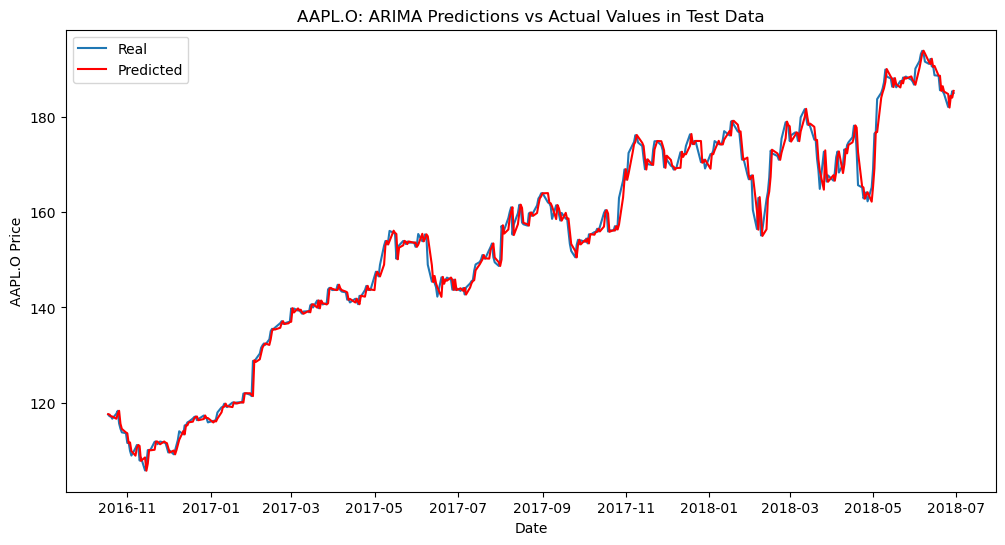

In [133]:
# Compare the test data with predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(testL, label='Real')
plt.plot(AAPL[sizeL:].index, pre_AAPL, color='red', label='Predicted')
plt.title('AAPL.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('AAPL.O Price')
plt.legend()
plt.show()

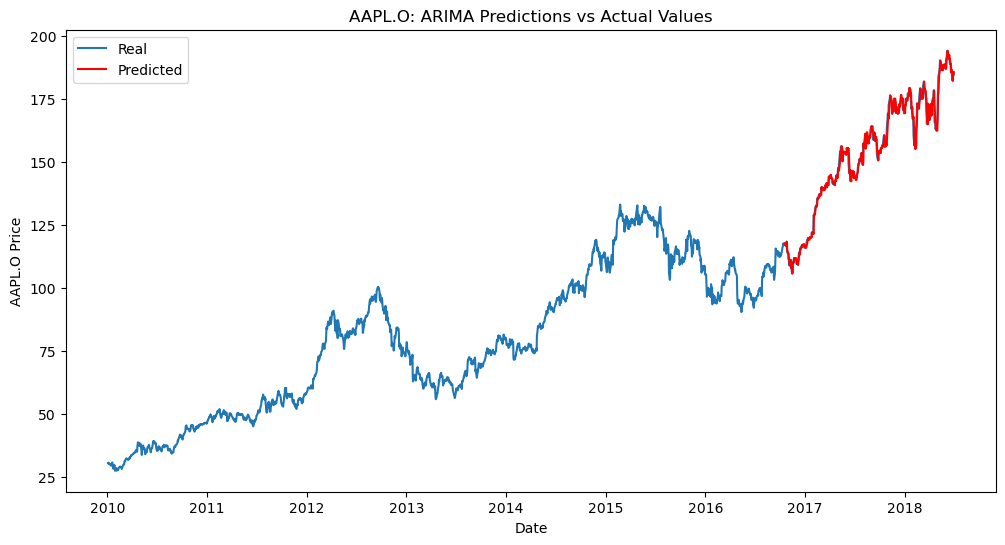

In [134]:
# Compare AAPL.O prices with predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(AAPL, label='Real')
plt.plot(AAPL[sizeL:].index, pre_AAPL, color='red', label='Predicted')
plt.title('AAPL.O: ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('AAPL.O Price')
plt.legend()
plt.show()

In [135]:
dataAAPL = pd.DataFrame(data['AAPL.O'].dropna()[int(len(AAPL.values) * 0.8):])
dataAAPL['Returns'] = np.log(dataAAPL['AAPL.O'] / dataAAPL['AAPL.O'].shift(1))
dataAAPL['direction'] = np.sign(dataAAPL['Returns']).dropna().astype(int)
dataAAPL['pre']= pre_AAPL
dataAAPL['lag_1'] = dataAAPL['pre'].shift(1)
dataAAPL['lag_2'] = dataAAPL['pre'].shift(2)
dataAAPL['pre_sign']= np.sign(dataAAPL['lag_2'])
dataAAPL['Returns_A'] = dataAAPL['pre_sign'] * dataAAPL['Returns']
# total return
np.exp(np.sum(dataAAPL['Returns_A']))

1.580515710382514

In [136]:
# compare the total return with the benchmark strategy
dataAAPL[['Returns', 'Returns_A']].sum().apply(np.exp)

Returns      1.575807
Returns_A    1.580516
dtype: float64

In [137]:
#MSFT.O (5,2,0) -> (1,1,0)

In [138]:
bestmodel = auto_arima(MSFT, seasonal=False, trace=True).order
print(bestmodel)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.30 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=6024.460, Time=0.25 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5383.959, Time=0.20 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=6022.460, Time=0.05 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5005.052, Time=0.29 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=4860.979, Time=0.36 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=4818.049, Time=0.44 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=4748.345, Time=0.56 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.48 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.57 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=4746.345, Time=0.29 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=4816.049, Time=0.26 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.47 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.08 s

In [139]:
pre_MSFT = get_pre(MSFT, (1,1,0))

In [140]:
sizeM = int(len(MSFT.values) * 0.8)
testM = MSFT[sizeM:]

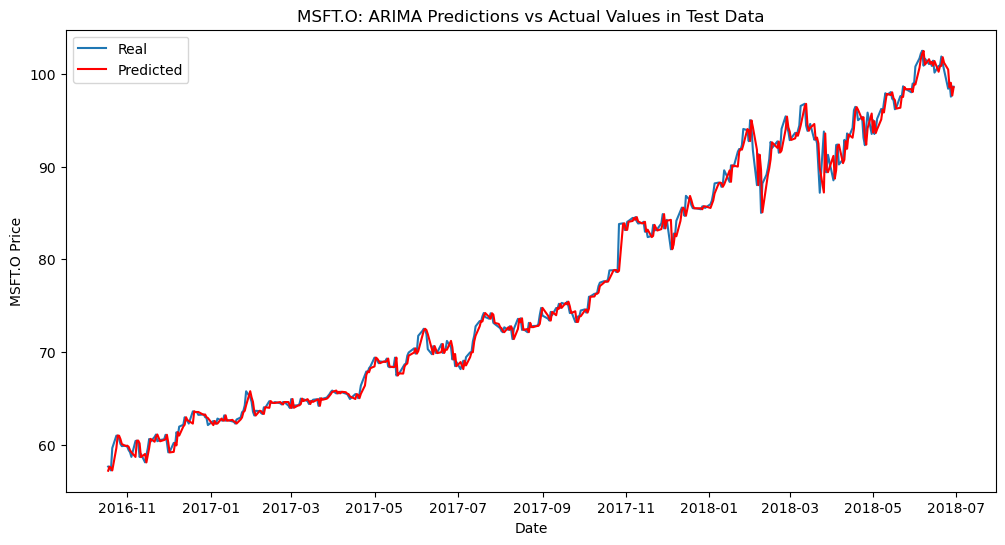

In [141]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(testM, label='Real')
plt.plot(MSFT[sizeL:].index, pre_MSFT, color='red', label='Predicted')
plt.title('MSFT.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('MSFT.O Price')
plt.legend()
plt.show()

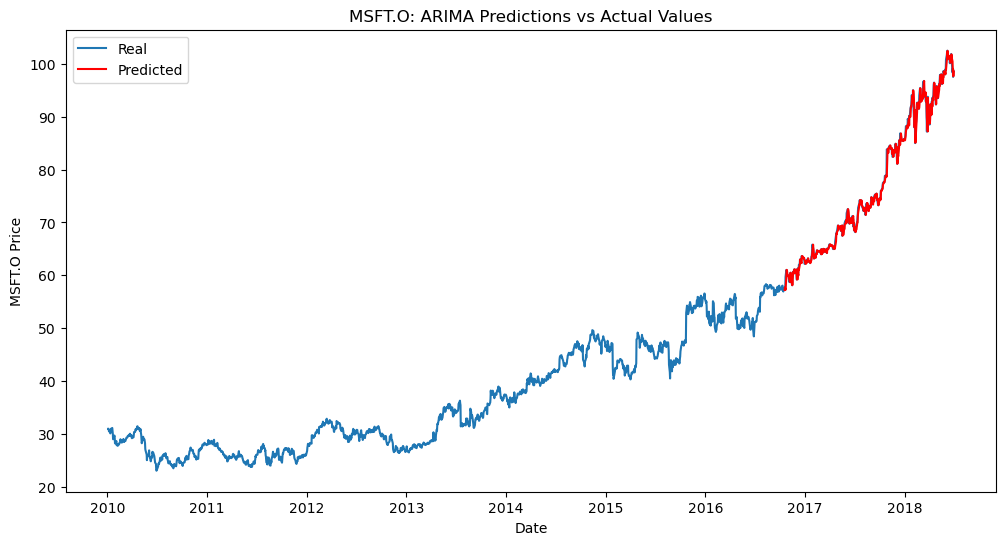

In [142]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(MSFT, label='Real')
plt.plot(MSFT[sizeM:].index, pre_MSFT, color='red', label='Predicted')
plt.title('MSFT.O: ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('MSFT.O Price')
plt.legend()
plt.show()

In [143]:
dataMSFT = pd.DataFrame(data['MSFT.O'].dropna()[int(len(MSFT.values) * 0.8):])
dataMSFT['Returns'] = np.log(dataMSFT['MSFT.O'] / dataMSFT['MSFT.O'].shift(1))
dataMSFT['direction'] = np.sign(dataMSFT['Returns']).dropna().astype(int)
dataMSFT['pre'] = pred_MSFT
dataMSFT['lag_1'] = dataMSFT['pre'].shift(1)
dataMSFT['lag_2'] = dataMSFT['pre'].shift(2)
dataMSFT['pre_sign']= np.sign(dataMSFT['lag_2'])
dataMSFT['Returns_M'] = dataMSFT['pre_sign'] * dataMSFT['Returns']
# total return
np.exp(np.sum(dataMSFT['Returns_M']))

1.7140622284025726

In [144]:
# compare the total return with the benchmark strategy
dataMSFT[['Returns', 'Returns_M']].sum().apply(np.exp)

Returns      1.710198
Returns_M    1.714062
dtype: float64

In [145]:
#INTC.O (2,1,2) -> (0,1,2)

In [146]:
bestmodel = auto_arima(INTC, seasonal=False, trace=True).order
print(bestmodel)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2822.105, Time=2.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2848.789, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2842.985, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2842.800, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2848.543, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2839.391, Time=1.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2838.317, Time=1.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2823.851, Time=6.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2838.799, Time=1.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2844.776, Time=1.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2837.518, Time=2.55 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2839.482, Time=1.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=6.29 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2821.989, Time=1.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [155]:
pre_INTC = get_pre(INTC, (0,1,2))

In [156]:
sizeI = int(len(INTC.values) * 0.8)
testI = INTC[sizeI:]

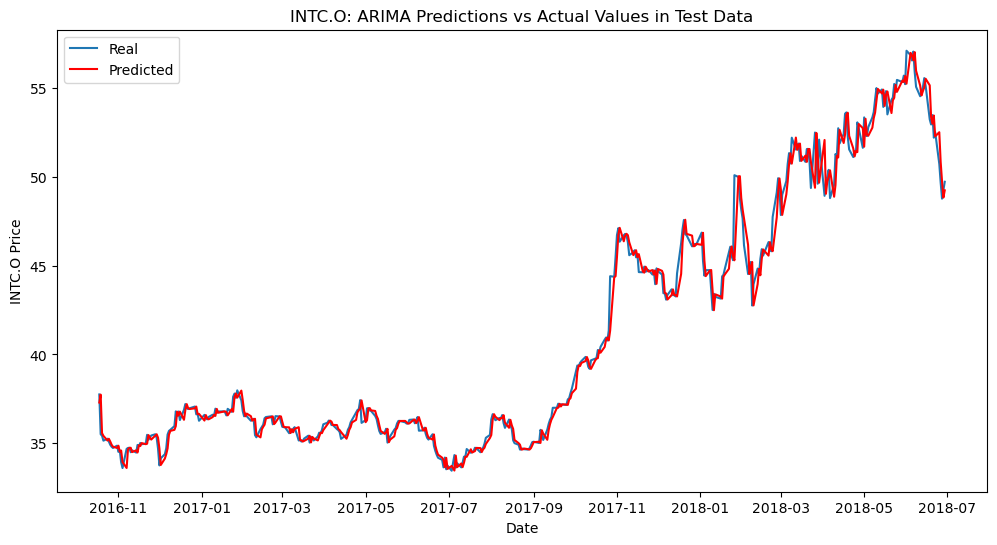

In [157]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(testI, label='Real')
plt.plot(INTC[sizeI:].index, pre_INTC, color='red', label='Predicted')
plt.title('INTC.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('INTC.O Price')
plt.legend()
plt.show()

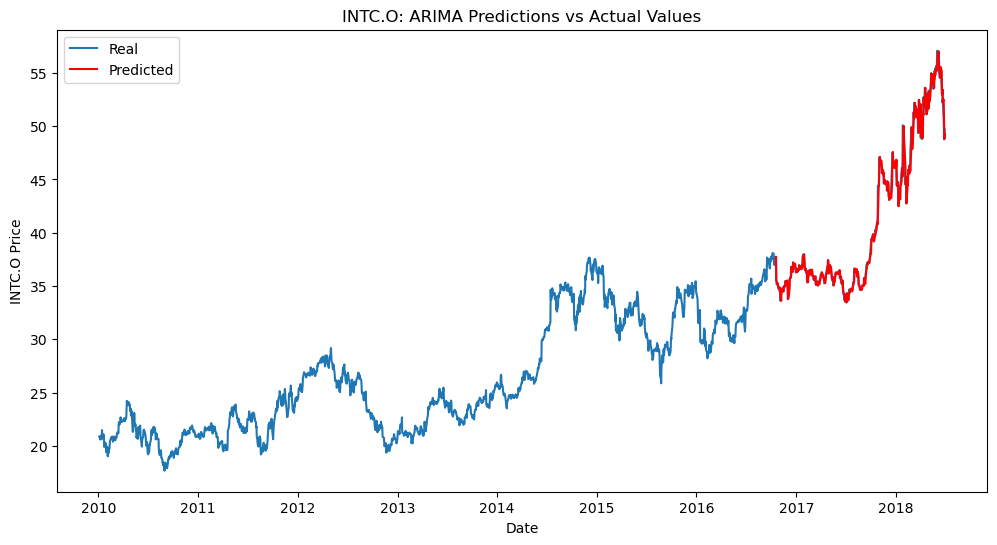

In [158]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(INTC, label='Real')
plt.plot(INTC[sizeI:].index, pre_INTC, color='red', label='Predicted')
plt.title('INTC.O: ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('INTC.O Price')
plt.legend()
plt.show()

In [159]:
dataINTC = pd.DataFrame(data['INTC.O'].dropna()[int(len(INTC.values) * 0.8):])
dataINTC['Returns'] = np.log(dataINTC['INTC.O'] / dataINTC['INTC.O'].shift(1))
dataINTC['direction'] = np.sign(dataINTC['Returns']).dropna().astype(int)
dataINTC['pre'] = pred_INTC
dataINTC['lag_1'] = dataINTC['pre'].shift(1)
dataINTC['lag_2'] = dataINTC['pre'].shift(2)
dataINTC['pre_sign']= np.sign(dataINTC['lag_2'])
dataINTC['Returns_I'] = dataINTC['pre_sign'] * dataINTC['Returns']
# total return
np.exp(np.sum(dataINTC['Returns_I']))

1.3998873556744589

In [160]:
# compare the total return with the benchmark strategy
dataINTC[['Returns', 'Returns_I']].sum().apply(np.exp)

Returns      1.316821
Returns_I    1.399887
dtype: float64

In [161]:
#AMZN.O (5,2,0) -> (1,1,0)

In [162]:
bestmodel = auto_arima(AMZN, seasonal=False, trace=True).order
print(bestmodel)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.34 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=17462.964, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=16848.387, Time=0.17 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=17460.964, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=16656.993, Time=0.35 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=16526.541, Time=0.59 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=16404.947, Time=0.71 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=16308.185, Time=0.95 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.47 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=16306.185, Time=0.41 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=16402.948, Time=0.31 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.43 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Ti

In [163]:
pre_AMZN = get_pre(AMZN, (0,1,0))

In [164]:
sizeA = int(len(AMZN.values) * 0.8)
testA = AMZN[sizeA:]

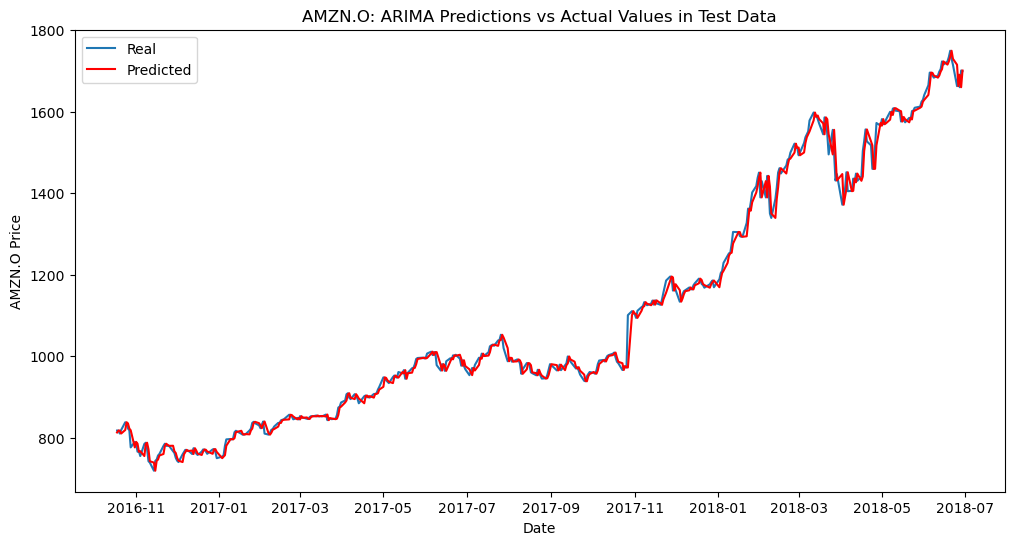

In [165]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(testA, label='Real')
plt.plot(AMZN[sizeA:].index, pre_AMZN, color='red', label='Predicted')
plt.title('AMZN.O: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('AMZN.O Price')
plt.legend()
plt.show()

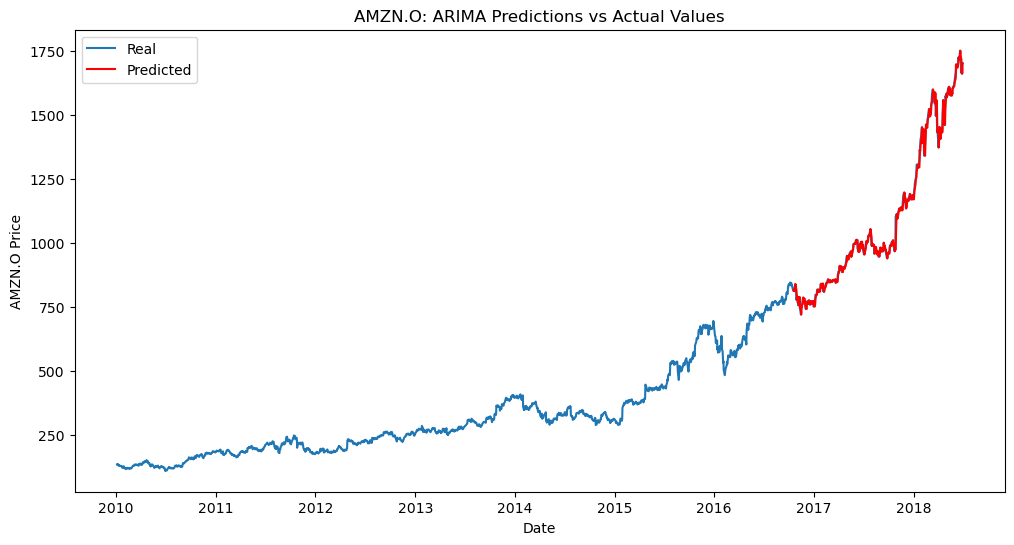

In [166]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(AMZN, label='Real')
plt.plot(AMZN[sizeA:].index, pre_AMZN, color='red', label='Predicted')
plt.title('AMZN.O: ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('AMZN.O Price')
plt.legend()
plt.show()

In [167]:
dataAMZN = pd.DataFrame(data['AMZN.O'].dropna()[int(len(AMZN.values) * 0.8):])
dataAMZN['Returns'] = np.log(dataAMZN['AMZN.O'] / dataAMZN['AMZN.O'].shift(1))
dataAMZN['direction'] = np.sign(dataAMZN['Returns']).dropna().astype(int)
dataAMZN['pre'] = pred_AMZN
dataAMZN['lag_1'] = dataAMZN['pre'].shift(1)
dataAMZN['lag_2'] = dataAMZN['pre'].shift(2)
dataAMZN['pre_sign']= np.sign(dataAMZN['lag_2'])
dataAMZN['Returns_Z'] = dataAMZN['pre_sign'] * dataAMZN['Returns']
# total return
np.exp(np.sum(dataAMZN['Returns_Z']))

2.078782912839833

In [168]:
# compare the total return with the benchmark strategy
dataAMZN[['Returns', 'Returns_Z']].sum().apply(np.exp)

Returns      2.078885
Returns_Z    2.078783
dtype: float64

In [169]:
#GS.N (1,1,0)

In [170]:
bestmodel = auto_arima(GS, seasonal=False, trace=True).order
print(bestmodel)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10231.913, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10233.667, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10231.514, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10231.543, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10231.818, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10233.504, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10233.507, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10235.502, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=10229.678, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=10231.667, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=10231.671, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=10229.708, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=10233.666, Time=0.12 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.246 seconds
(1, 1, 0)

In [171]:
pre_GS = get_pre(GS, (1,1,0))

In [172]:
sizeG = int(len(GS.values) * 0.8)
testG = GS[sizeG:]

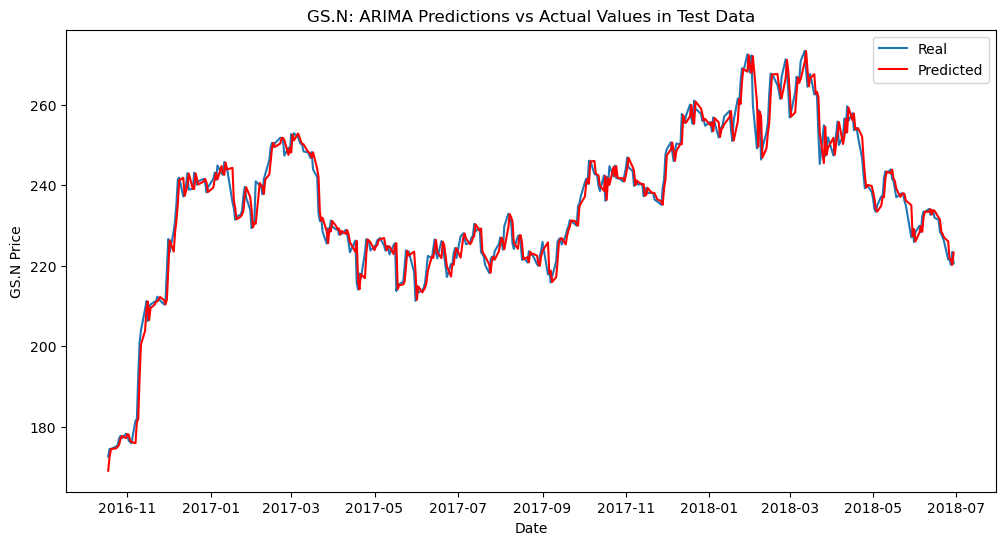

In [173]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(testG, label='Real')
plt.plot(GS[sizeG:].index, pre_GS, color='red', label='Predicted')
plt.title('GS.N: ARIMA Predictions vs Actual Values in Test Data')
plt.xlabel('Date')
plt.ylabel('GS.N Price')
plt.legend()
plt.show()

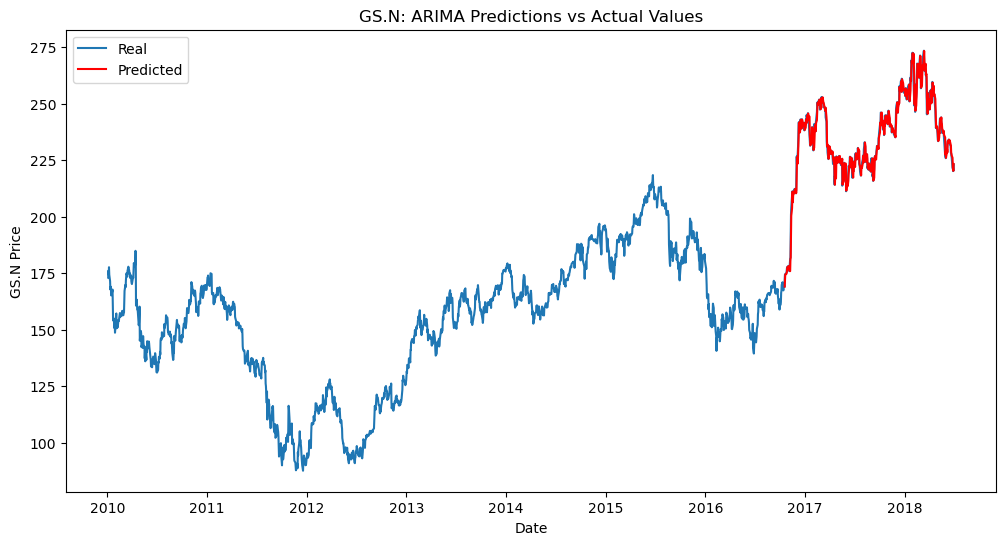

In [174]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(GS, label='Real')
plt.plot(GS[sizeG:].index, pre_GS, color='red', label='Predicted')
plt.title('GS.N: ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('GS.N Price')
plt.legend()
plt.show()

In [175]:
dataGS = pd.DataFrame(data['GS.N'].dropna()[int(len(GS.values) * 0.8):])
dataGS['Returns'] = np.log(dataGS['GS.N'] / dataGS['GS.N'].shift(1))
dataGS['direction'] = np.sign(dataGS['Returns']).dropna().astype(int)
dataGS['pre'] = pred_GS
dataGS['lag_1'] = dataGS['pre'].shift(1)
dataGS['lag_2'] = dataGS['pre'].shift(2)
dataGS['pre_sign']= np.sign(dataGS['lag_2'])
dataGS['Returns_G'] = dataGS['pre_sign'] * dataGS['Returns']
# total return
np.exp(np.sum(dataGS['Returns_G']))

1.2639390292819888

In [176]:
# compare the total return with the benchmark strategy
dataGS[['Returns', 'Returns_G']].sum().apply(np.exp)

Returns      1.277704
Returns_G    1.263939
dtype: float64